ERROR:yfinance:$BRK.B: possibly delisted; no price data found  (period=1d) (Yahoo error = "No data found, symbol may be delisted")


Error fetching price for BRK.B: single positional indexer is out-of-bounds
  Stock  Underlying  Strike   Call    Put  Time_to_Exp(yrs)  Theoretical  \
0  AAPL  223.889999   225.0   2.08   3.15               0.0        -1.11   
1  GOOG  158.860001   160.0   1.61   2.96               0.0        -1.14   
2  MSFT  382.140015   382.5   4.55   4.60               0.0        -0.36   
3  AMZN  196.009995   195.0   3.78   2.65               0.0         1.01   
4  TSLA  282.760010   282.5   8.72   8.38               0.0         0.26   
5  META  583.929993   585.0   9.74  10.12               0.0        -1.07   
6  NFLX  935.520020   935.0  15.00  13.44               0.0         0.52   
7  NVDA  110.419998   110.0   2.43   2.04               0.0         0.42   
8   JPM  245.820007   245.0   3.11   3.25               0.0         0.82   

   Market  Parity_Diff              Arbitrage  
0   -1.07         0.04           No Arbitrage  
1   -1.35        -0.21           No Arbitrage  
2   -0.05         0.

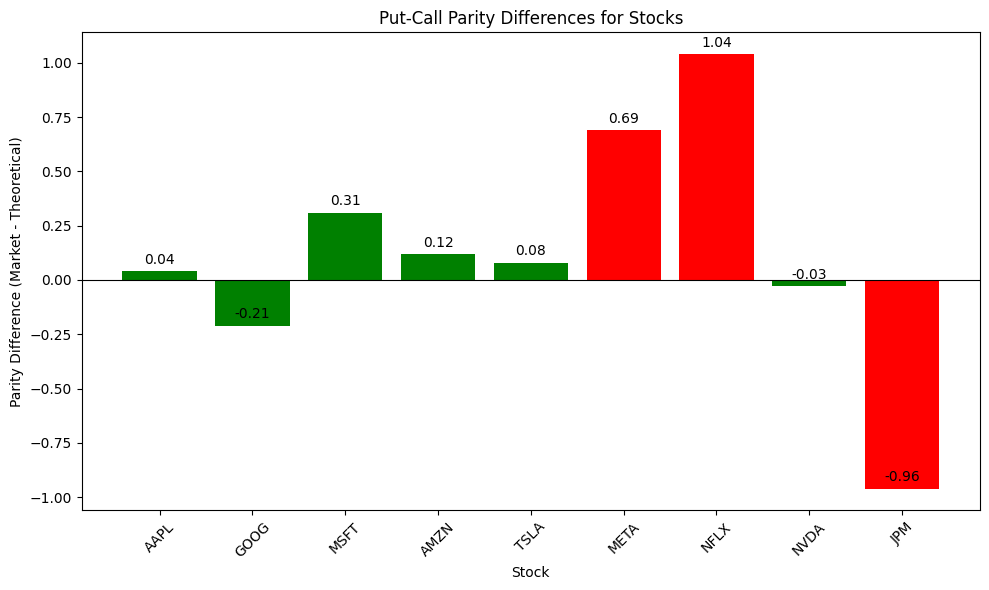

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Set risk-free rate (annualized) and arbitrage threshold (in dollars)
r = 0.05
arbitrage_threshold = 0.5

# List of 10 stocks (adjust as needed; updated "FB" -> "META", etc.)
stocks = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA", "META", "NFLX", "NVDA", "BRK.B", "JPM"]

results = []

for ticker_symbol in stocks:
    ticker = yf.Ticker(ticker_symbol)

    # Get current underlying price (most recent close)
    try:
        hist = ticker.history(period="1d")
        S = hist["Close"].iloc[-1]
    except Exception as e:
        print(f"Error fetching price for {ticker_symbol}: {e}")
        continue

    # Get list of available expiration dates for options
    expirations = ticker.options
    if not expirations:
        print(f"No option data for {ticker_symbol}")
        continue

    # Filter out past expirations and pick the nearest future expiration
    valid_expirations = [
        e for e in expirations
        if datetime.strptime(e, "%Y-%m-%d") > datetime.today()
    ]
    if not valid_expirations:
        print(f"No valid future expiration date for {ticker_symbol}")
        continue

    # Choose the earliest valid expiration
    nearest_exp = valid_expirations[0]
    exp_date = datetime.strptime(nearest_exp, "%Y-%m-%d")
    today = datetime.today()
    T = (exp_date - today).days / 365.0  # time to expiration in years

    # Retrieve the option chain for the chosen expiration
    try:
        opt_chain = ticker.option_chain(nearest_exp)
    except Exception as e:
        print(f"Error fetching option chain for {ticker_symbol}: {e}")
        continue

    calls = opt_chain.calls.copy()
    puts = opt_chain.puts.copy()

    if calls.empty or puts.empty:
        print(f"No calls or puts data for {ticker_symbol} on {nearest_exp}")
        continue

    # Identify the strike price closest to the underlying price S
    calls["diff"] = abs(calls["strike"] - S)
    closest_call_idx = calls["diff"].idxmin()
    if pd.isna(closest_call_idx):
        print(f"No ATM call found for {ticker_symbol}")
        continue
    closest_call = calls.loc[closest_call_idx]
    strike = closest_call["strike"]
    call_price = closest_call["lastPrice"]

    # Find the corresponding put option for the same strike
    put_row = puts[puts["strike"] == strike]
    if put_row.empty:
        print(f"No matching put for strike {strike} for {ticker_symbol}")
        continue
    put_price = put_row.iloc[0]["lastPrice"]

    # Calculate put-call parity
    # Theoretical: S - K * exp(-rT)
    theoretical_diff = S - strike * np.exp(-r * T)
    # Market observed: call - put
    market_diff = call_price - put_price
    # Deviation
    parity_diff = market_diff - theoretical_diff

    # Arbitrage check
    arbitrage_signal = "Arbitrage Opportunity" if abs(parity_diff) > arbitrage_threshold else "No Arbitrage"

    results.append({
        "Stock": ticker_symbol,
        "Underlying": S,
        "Strike": strike,
        "Call": call_price,
        "Put": put_price,
        "Time_to_Exp(yrs)": round(T, 3),
        "Theoretical": round(theoretical_diff, 2),
        "Market": round(market_diff, 2),
        "Parity_Diff": round(parity_diff, 2),
        "Arbitrage": arbitrage_signal
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)
print(df)

# If the DataFrame is empty, stop
if df.empty:
    print("No valid data to plot. All symbols were skipped.")
else:
    # Create a bar plot of the parity differences for each stock
    plt.figure(figsize=(10, 6))
    colors = ["red" if abs(val) > arbitrage_threshold else "green" for val in df["Parity_Diff"]]
    bars = plt.bar(df["Stock"], df["Parity_Diff"], color=colors)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel("Stock")
    plt.ylabel("Parity Difference (Market - Theoretical)")
    plt.title("Put-Call Parity Differences for Stocks")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Annotate each bar with the value of the parity difference
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.show()